In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
def get_random_cell(grid):
    while True:
        x = random.randint(0, grid.shape[0] - 1)
        y = random.randint(0, grid.shape[1] - 1)
        if grid[x, y] == 0:  # if the cell is not an obstacle
            return x, y

In [3]:
def read_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()  # list of strings, each string is a line of the file

    grid = np.array([list(map(int, line.strip()))
                     for line in lines[1:]])  # grid is a matrix of 1s and 0s
    grid_reversed = np.flip(grid, axis=0)

    return grid_reversed

In [4]:
def get_reward(state, action, goal, grid, obstacle_punishment, wait_punishment):
    goal_x, goal_y = goal
    distance = np.linalg.norm(np.array([goal_x, goal_y]) - state)

    if grid[state] == 1:
        return obstacle_punishment  # obstacle
    elif np.array_equal(state, goal):
        return 100
    elif action == (0, 0) and not np.array_equal(state, goal):
        return wait_punishment  # wait action in non-goal state
    else:
        return -distance  # default case

In [5]:
def get_next_state(state, action, action_probabilities, grid, goal):
    # each action has 3 possible outcomes
    action_mapping = {
        (-1, 1): [(-1, 0), (-1, 1), (0, 1)],
        (0, 1): [(-1, 1), (0, 1), (1, 1)],
        (1, 1): [(0, 1), (1, 1), (1, 0)],
        (-1, 0): [(-1, -1), (-1, 0), (-1, 1)],
        (0, 0): [(0, 0), (0, 0), (0, 0)],
        (1, 0): [(1, 1), (1, 0), (1, -1)],
        (-1, -1): [(0, -1), (-1, -1), (-1, 0)],
        (0, -1): [(1, -1), (0, -1), (-1, -1)],
        (1, -1): [(0, 1), (1, -1), (-1, 0)]
    }

    possible_actions = action_mapping[action]
    # np.random.choice must receive a 1-dim list as first argument, or a scalar (and then it converts it to a list [0 .. scalar-1])
    actual_action_index = np.random.choice(len(possible_actions), p=action_probabilities)
    actual_action = possible_actions[actual_action_index]
    next_state = (state[0] + actual_action[0], state[1] + actual_action[1])

    # i move if next state is within bounds and i am not on an obstacle
    if grid[next_state] == 0 and not np.array_equal(state, goal):
        return next_state
    else:
        return state  # no movement if next state is out of bounds or i am currently on an obstacle

In [6]:
# now i know how to get the next state given one
def choose_action(state, actions, q_table, epsilon, montecarlo, policy):
    action_idx = None
    if montecarlo:
        action_idx = policy[state]
    else:
        if random.uniform(0, 1) < epsilon:
            # explore (get a random action)
            action_idx = random.randint(0, len(actions) - 1)
        else:
            # exploit (get the best action yet, argmax return index)
            action_idx = np.argmax(q_table[state[0], state[1]])

    return actions[action_idx]

In [7]:
def update_q_table_td(state, action_index, next_state, reward, q_table, gamma, alpha):
    best_q_value = np.max(q_table[next_state[0], next_state[1]])
    previous_q_value = q_table[state[0], state[1], action_index]
    increment = reward + gamma * best_q_value - previous_q_value
    q_table[state[0], state[1], action_index] += alpha * increment

In [8]:
def generate_episode(state, goal, grid, q_table, params, montecarlo, policy):  # generate 1 (complete) episode
    episode = {"states":[], "actions":[], "rewards":[]}
    
    while not np.array_equal(state, goal) and len(episode["states"]) < params['max_episode_length']:
        # choose the best action with "epsilon-greedy policy"
        action = choose_action(state, params['actions'], q_table, params['epsilon'], montecarlo, policy)
        
        # apply action and observe next state and reward
        next_state = get_next_state(state, action, params['action_probabilities'], grid, goal)
        reward = get_reward(state, action, goal, grid, params['obstacle_punishment'], params['wait_punishment'])

        episode["states"].append(state)
        episode["actions"].append(action)
        episode["rewards"].append(reward)

        if not montecarlo:
            # update q_table
            action_index = params['actions'].index(action)
            update_q_table_td(state, action_index, next_state, reward, q_table, params['gamma'], params['alpha'])

        state = next_state

    return episode

In [9]:
# after generating all the episodes, i can get the best policy from the q_table:
def get_policy(grid, goal, q_table):
    policy = np.zeros_like(grid, dtype=int)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not np.array_equal((i, j), goal):
                # in state (i,j), choose the action with the highest q-value
                policy[i, j] = np.argmax(q_table[i, j])
    return policy

In [10]:
def plot_policy(goal, grid, actions, policy):
    fig, ax = plt.subplots()
    # draw arrows representing the action in each cell
    U = np.zeros_like(grid, dtype=float)
    V = np.zeros_like(grid, dtype=float)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not np.array_equal((i, j), goal):
                action = actions[policy[i, j]]
                U[i, j] = action[1]
                V[i, j] = action[0]
            if grid[i, j] == 1:
                # draw a black square on obstacle cell
                ax.fill([j, j, j+1, j+1], [i, i+1, i+1, i], "k")

    ax.quiver(U, V)
    ax.scatter(goal[1], goal[0], color="r")  # draw a red dot on the goal cell
    plt.show()

In [11]:
# now i can put everything together:
def q_learning(state, goal, grid, params):
    # initialize q_table with zeros
    q_table = np.zeros((grid.shape[0], grid.shape[1], 9))

    # lists to store total rewards and episode lengths
    rewards = []
    episode_lengths = []

    for _ in tqdm(range(params['episodes_number']), desc="Episode", colour="red"):
        episode = generate_episode(state, goal, grid, q_table, params, False, None)
        rewards.append(np.sum(episode["rewards"]))
        episode_lengths.append(len(episode["states"]))

    policy = get_policy(grid, goal, q_table)
    if params['plot_map']:
        plot_policy(goal, grid, params['actions'], policy)
    return policy, rewards, episode_lengths

In [12]:
def update_q_table_montecarlo(racum, state, rewards, action_index, gamma, policy, q_table):
    utility = np.sum(gamma ** np.arange(len(rewards)) * rewards)

    racum[state][action_index].append(utility)
    q_table[state][action_index] = np.mean(racum[state][action_index])
    policy[state] = np.argmax(q_table[state])


In [13]:
def montecarlo(state, goal, grid, params):
    rewards = []
    episode_lengths = []
    policy = np.zeros_like(grid, dtype=int)

    #initialize q_table with zeros
    q_table = np.zeros((grid.shape[0], grid.shape[1], 9))
    
    #initialize racum with empty lists
    racum = np.empty((grid.shape[0], grid.shape[1], 9), dtype=object)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            for a in range(9):
                racum[x, y, a] = []
                
    for e in tqdm(range(params['episodes_number']), colour="blue", desc="Episode"):
        episode = generate_episode(state, goal, grid, q_table, params, True, policy)

        #initialize first visit tables
        first_visit_table = np.full((grid.shape[0], grid.shape[1], 9), True)
        #algorithm excution

        for i,(state,action) in enumerate(zip(episode['states'], episode['actions'])):
            if params["each_visit_montecarlo"] or first_visit_table[tuple(state)][params["actions"].index(action)]:
                first_visit_table[tuple(state)][params["actions"].index(action)] = False
                update_q_table_montecarlo(racum, state,episode['rewards'][i:], params["actions"].index(action), params['gamma'], policy,q_table)
        rewards.append(np.sum(episode['rewards']))
        episode_lengths.append(len(episode['states']))

    if params['plot_map']:
        plot_policy(goal, grid, params['actions'], policy)
    return policy, rewards, episode_lengths          




In [14]:
def compare_algorithms(algorithms, params):

    grid = read_input(params['file_path'])

    # initialize lists to store results
    total_rewards = {name: [] for name in algorithms.keys()}
    total_lengths = {name: [] for name in algorithms.keys()}

    for run in tqdm(range(params['runs']), desc="Runs"):

        # generate random initial state and goal (the same for all algorithms)
        state = get_random_cell(grid)
        goal = get_random_cell(grid)

        for name, algorithm in algorithms.items():
            # run algorithm (the first object returned is the policy, which is not needed here)
            _, rewards, lengths = algorithm(state, goal, grid, params)

            # accumulate results
            total_rewards[name].append(rewards)
            total_lengths[name].append(lengths)

    avg_rewards = {name: np.mean(total_rewards[name], axis=0) for name in algorithms.keys()}
    avg_lengths = {name: np.mean(total_lengths[name], axis=0) for name in algorithms.keys()}

    return avg_rewards, avg_lengths

In [15]:
def plot_comparison(avg_rewards, avg_lengths):

    fig, axs = plt.subplots(2)

    colors = {"q_learning": "red", "montecarlo": "blue"}

    for name in avg_rewards.keys():
        axs[0].plot(avg_rewards[name], label=name, color=colors[name])
        axs[1].plot(avg_lengths[name], label=name, color=colors[name])

    axs[0].set_xlabel("Run")
    axs[0].set_ylabel("Average Reward")
    axs[0].legend()

    axs[1].set_xlabel("Run")
    axs[1].set_ylabel("Average Episode Length")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [16]:
def create_sliders():
    sliders = {
        'episodes_number_slider': widgets.IntSlider(min=1, max=10000, step=1, value=500, description='Episodes Number'),
        'max_episode_length_slider': widgets.IntSlider(min=1, max=10000, step=1, value=500, description='Max Episode Length'),
        'runs_slider': widgets.IntSlider(min=1, max=100, step=1, value=50, description='Runs'),
        'obstacle_punishment_slider': widgets.FloatSlider(min=-1000, max=0, step=1, value=-500, description='Obstacle Punishment'),
        'wait_punishment_slider': widgets.FloatSlider(min=-1000, max=0, step=1, value=-500, description='Wait Punishment'),
        'alpha_slider': widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Alpha'),
        'gamma_slider': widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Gamma'),
        'epsilon_slider': widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Epsilon'),
        'plot_map': widgets.Checkbox(value=False, description='Plot Map'),
        'each_visit_montecarlo': widgets.Checkbox(value=False, description='Each visit Montecarlo')
    }
    return sliders

In [17]:
action_probabilities = [0, 1, 0]
file_path = "../resources/small_map.txt"
actions = [(-1, 1), (0, 1), (1, 1),
           (-1, 0), (0, 0), (1, 0),
           (-1, -1), (0, -1), (1, -1)]

In [18]:
def on_play_button_clicked(b, sliders):
    clear_output(wait=True)
    # get the values from the sliders
    params = {
        'file_path': file_path,
        'actions': actions,
        'action_probabilities': action_probabilities,
        'episodes_number': sliders['episodes_number_slider'].value,
        'max_episode_length': sliders['max_episode_length_slider'].value,
        'runs': sliders['runs_slider'].value,
        'obstacle_punishment': sliders['obstacle_punishment_slider'].value,
        'wait_punishment': sliders['wait_punishment_slider'].value,
        'alpha': sliders['alpha_slider'].value,
        'gamma': sliders['gamma_slider'].value,
        'epsilon': sliders['epsilon_slider'].value,
        'plot_map': sliders['plot_map'].value,
        'each_visit_montecarlo': sliders['each_visit_montecarlo'].value
    }

    algorithms = {"q_learning": q_learning, "montecarlo": montecarlo}
    avg_rewards, avg_lengths = compare_algorithms(algorithms, params)
    plot_comparison(avg_rewards, avg_lengths)

In [19]:
def create_panel():
    sliders = create_sliders()
    for slider in sliders.values():
        display(slider)

    play_button = widgets.Button(description="Play")
    play_button.on_click(lambda b: on_play_button_clicked(b, sliders))
    display(play_button)

Runs:   0%|          | 0/50 [00:00<?, ?it/s]

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

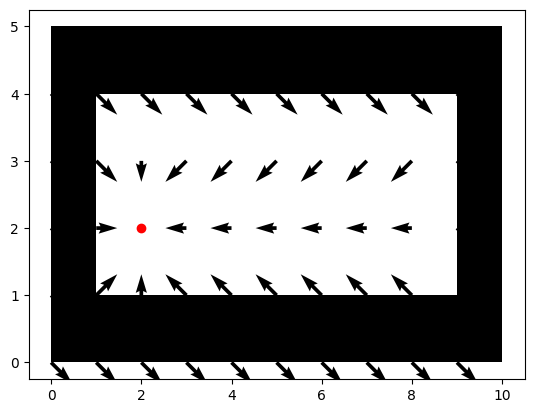

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

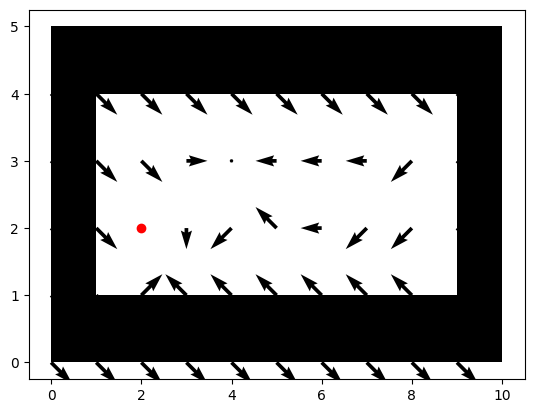

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

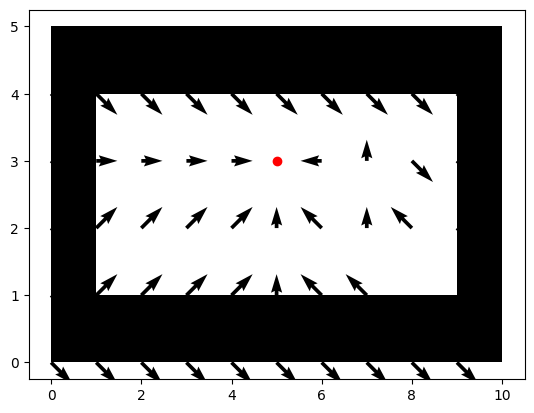

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

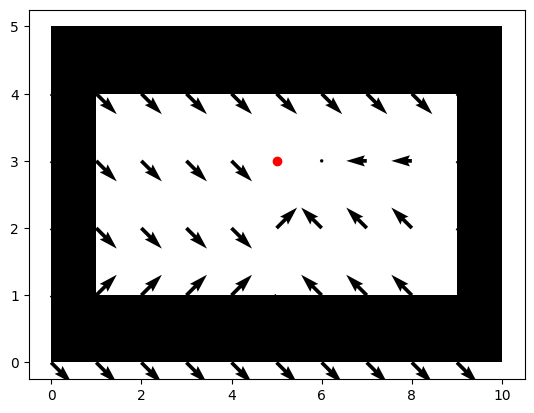

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

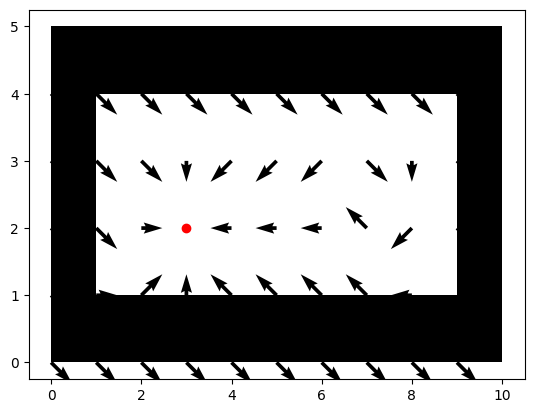

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

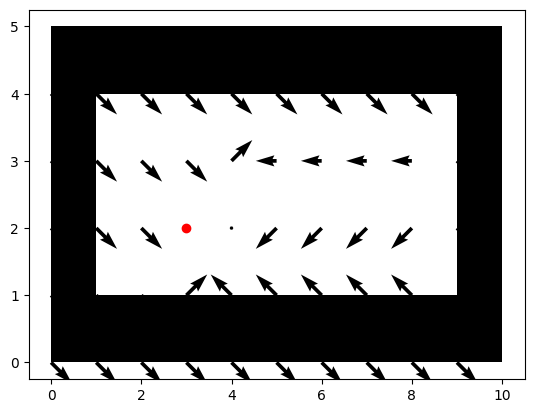

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

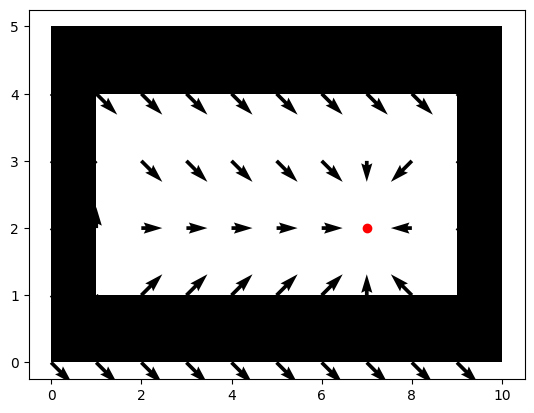

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

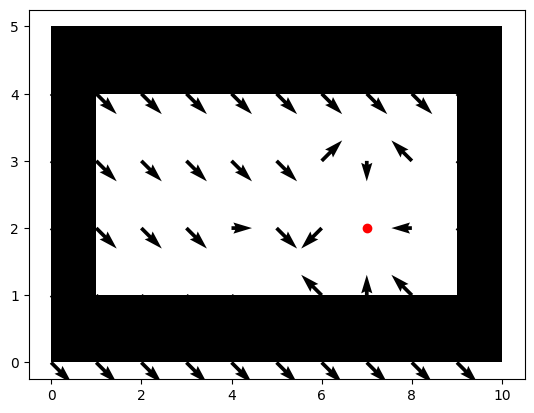

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

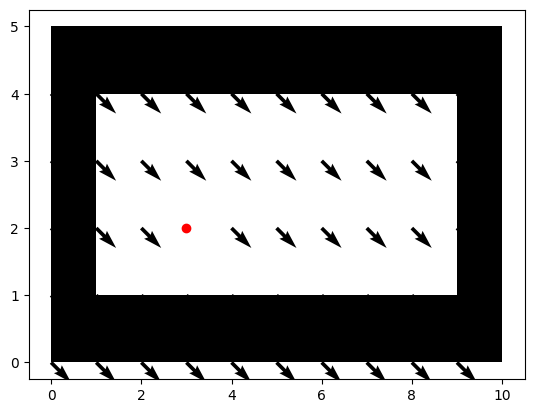

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

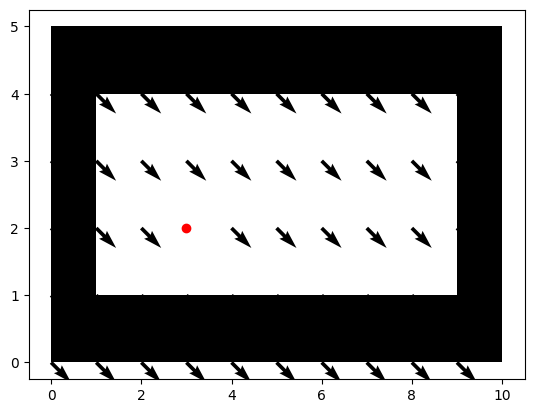

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

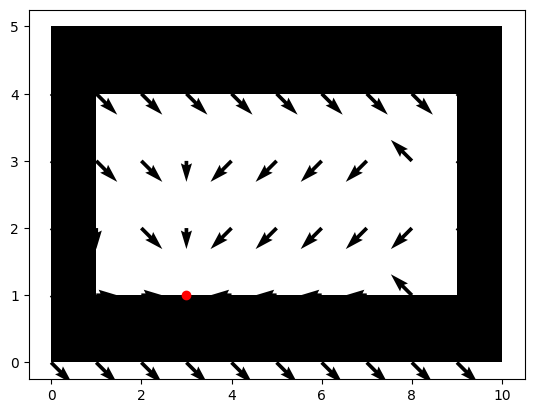

Episode:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
create_panel()